In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

In [2]:
row_data = pd.read_csv("training.csv")

In [3]:
def fill_price(df, col):
    # I'm not sure what is the best way to fill prices
    df[col].fillna(df[col].mean(), inplace = True)

In [4]:
def data_fillna(df):
    res = df.drop(['RefId', 'WheelTypeID'], axis = 1)
    # I'll drop Model for now, as I don't know how to correctly encode it.
    # Making 1063 labels with one hot encoding looks bad for me, as I would use knn.
    # The same for Trim and SubModel, maybe I would need some text processing later
    # to extract features from SubModel such as 'Wagon', 'Sedan', 'Sport' etc, but I'm not there yet
    res = res.drop(['Model', 'Trim', 'SubModel'], axis = 1) 
    
    res['WheelType'].fillna('NotSpecified', inplace = True)
    
    res['PRIMEUNIT'].fillna("NO", inplace = True)
    res['AUCGUART'].fillna('RED', inplace = True)
    
    primeunit = {'NO': 0, 'YES': 1}
    # yellow exists in dataset description
    # we assume that RED < YELLOW < GREEN
    aucguart = {'RED': -1, 'YELLOW': 0, 'GREEN': 1} 
    
    res['PRIMEUNIT'].replace(primeunit, inplace = True)
    res['AUCGUART'].replace(aucguart, inplace = True)
    
    res['TopThreeAmericanName'].fillna('OTHER', inplace = True)

    res['AutoTransmition'] = res.apply(lambda t: t['Transmission'] == 'AUTO', axis = 1).astype(np.int64)
    res = res.drop('Transmission', axis = 1)
    
    # maybe we can do better, but as we have only 5 instances without Size, lets do stupid things
    res['Size'].fillna('MEDIUM', inplace = True) 
    
    # I think VNST gives enough information about state
    # as VNST zipcode is categorial feature, but with more instances, so I'll remove it
    res = res.drop('VNZIP1', axis = 1)
    
    # I don't really understand this feature, so, I'll ignore it for now, 
    # As it will grow my feature space to 74 features
    res = res.drop('BYRNO', axis = 1)
    
    res['Nationality'].fillna('OTHER', inplace = True)
    
    res['Color'].fillna('NOT AVAIL', inplace = True)
    
    fill_price(res, "MMRAcquisitionAuctionAveragePrice")
    fill_price(res, "MMRAcquisitionAuctionCleanPrice")
    fill_price(res, "MMRAcquisitionRetailAveragePrice")
    fill_price(res, "MMRAcquisitonRetailCleanPrice")
    fill_price(res, "MMRCurrentAuctionAveragePrice")
    fill_price(res, "MMRCurrentAuctionCleanPrice")
    fill_price(res, "MMRCurrentRetailAveragePrice")
    fill_price(res, "MMRCurrentRetailCleanPrice")
    
    res['PurchDate'] = (pd.to_datetime(res['PurchDate']).astype(np.int64)/ 10**9).astype(np.int64)
    
    return res

In [5]:
preprocessed_data = data_fillna(row_data)

In [6]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()

def final_data_preparation(df):
    nonbinary_cols = list(filter(lambda c: df[c].dtype == object, df.columns))
    data_nonbinary = pd.get_dummies(df[nonbinary_cols])
    tmp = df.drop(nonbinary_cols, axis=1)
    tmp = pd.concat((tmp, data_nonbinary), axis = 1)
    # we normalize also binary data, assuming it is [0, 1]
    y = tmp['IsBadBuy'].get_values()
    X = tmp.drop('IsBadBuy', axis = 1).get_values()
    X = min_max_scaler.fit_transform(X)
    return (X, y)

In [7]:
X, y = final_data_preparation(preprocessed_data)

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

In [9]:
from imblearn.ensemble import BalancedRandomForestClassifier

forest = BalancedRandomForestClassifier (
    n_estimators=1000,
    criterion='gini',
    max_depth=10,
    bootstrap=True,
    oob_score=True,
    n_jobs=-1,
    random_state=23)

In [10]:
forest.fit(X_train, y_train)

BalancedRandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                               criterion='gini', max_depth=10,
                               max_features='auto', max_leaf_nodes=None,
                               max_samples=None, min_impurity_decrease=0.0,
                               min_samples_leaf=2, min_samples_split=2,
                               min_weight_fraction_leaf=0.0, n_estimators=1000,
                               n_jobs=-1, oob_score=True, random_state=23,
                               replacement=False, sampling_strategy='auto',
                               verbose=0, warm_start=False)

In [11]:
from sklearn.metrics import confusion_matrix

In [12]:
y_pred = forest.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[9446, 3459],
       [ 619, 1073]], dtype=int64)

In [13]:
test_err = []
train_err = []
oob_err = []
tree_count = np.logspace(2,3, num=30, dtype=int)
for n in tree_count:
    forest = BalancedRandomForestClassifier (
        n_estimators=n,
        criterion='gini',
        max_depth=10,
        bootstrap=True,
        oob_score=True,
        n_jobs=-1,
        random_state=23)
    forest.fit(X_train, y_train)
    y_train_pred = forest.predict(X_train)
    y_test_pred = forest.predict(X_test)
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))
    oob_err.append(1 - forest.oob_score_)

C:\ProgramData\Anaconda3\lib\site-packages\imblearn\ensemble\_forest.py:591: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\ProgramData\Anaconda3\lib\site-packages\imblearn\ensemble\_forest.py:591: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\ProgramData\Anaconda3\lib\site-packages\imblearn\ensemble\_forest.py:591: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\ProgramData\Anaconda3\lib\site-packages\imblearn\ensemble\_forest.py:591: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not

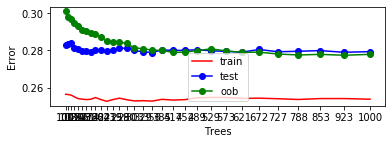

In [14]:
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)

plt.plot(tree_count, train_err, color='r', label = 'train')
plt.plot(tree_count, test_err, marker='o', linestyle='-', color='b', label = 'test')
plt.plot(tree_count, oob_err, marker='o', linestyle='-', color='g', label = 'oob')

plt.xlabel('Trees')

plt.xticks(tree_count)
plt.ylabel('Error')
plt.legend()
plt.show()

Вывод: с ростом числа деревьев точность возрастает. Переобучения не наступает, так как данных много и деревья не очень глубокие
Благодаря тому, что я использовал реализацию, которая учитывает несбалансированность выборки и позволяет обучать деревья на сбалансированных подмножествах
алгоритм нормально распознает второй класс.

In [17]:
from sklearn.ensemble import GradientBoostingClassifier

test_err = []
train_err = []
tree_count = np.logspace(2,3, num=30, dtype=int)
for n in tree_count:
    classifier = GradientBoostingClassifier (
        n_estimators=n,
        max_depth=4,
        subsample=0.9,
        random_state=23)
    classifier.fit(X_train, y_train)
    y_train_pred = classifier.predict(X_train)
    y_test_pred = classifier.predict(X_test)
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))

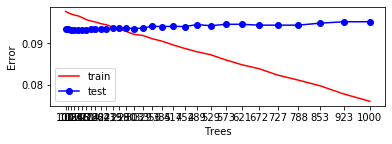

In [22]:
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)

plt.plot(tree_count, train_err, color='r', label = 'train')
plt.plot(tree_count, test_err, marker='o', linestyle='-', color='b', label = 'test')

plt.xlabel('Trees')

plt.xticks(tree_count)
plt.ylabel('Error')
plt.legend()
plt.show()

Вывод: наилучший результат получился на тех алгоритмах, которые нормльно работают с несбалансированными классами.
SVC и BalancedRandomForestClassifier
В остальных алгоритмах алгоритм хорошо определяет первый класс и плохо второй